In [495]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import re,os, glob, traceback
import matplotlib.dates as mdates

## 0. Read all csv files

In [496]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2019.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_e = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/junk/2019_emo.csv')
df_e.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_e = df_e.loc[:, ~df_e.columns.str.match('Unnamed')]

df_2019 = pd.merge(df, df_e[['id', 'user_id', 'race', 'emotion']],  how='left', on=['id','user_id'])
df_2019.shape

df.shape, df_e.shape, df_2019.shape

((2799726, 17), (1811516, 19), (2799726, 19))

In [497]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2020.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_e = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/junk/2020_emo.csv')
df_e.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_e = df_e.loc[:, ~df_e.columns.str.match('Unnamed')]

df_2020 = pd.merge(df, df_e[['id', 'user_id', 'race', 'emotion']],  how='left', on=['id','user_id'])
df_2020.shape

df.shape, df_e.shape, df_2020.shape

((3502171, 17), (2275943, 19), (3502171, 19))

In [501]:
df = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2021.csv')
df.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df = df.loc[:, ~df.columns.str.match('Unnamed')]

df_e = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/junk/2021_emo.csv')
df_e.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_e = df_e.loc[:, ~df_e.columns.str.match('Unnamed')]

df_2021 = pd.merge(df, df_e[['id', 'user_id', 'race', 'emotion']],  how='left', on=['id','user_id'])
df_2021.shape

df.shape, df_e.shape, df_2021.shape

((2553235, 17), (1723470, 19), (2553235, 19))

In [504]:
drug_keywords_map= {
'tobacco' : ['nicotine', 'tobacco', 'cigarette', 'cigarrette', 'cigar', 'bidis', 'snuff'],
'alcohol' : ['liquor', 'beer', 'wine'],
'cannabinoids' : ['marijuana', 'blunt', 'dope', 'ganja', 'grass', 'herb', 'joint', 'bud', 'mary jane', 'pot', 'reefer', 'green', 'trees', 'smoke', 'sinsemilla', 'skunk', 'weed','hashish', 'boom', 'gangster', 'hash', 'hash oil', 'hemp'],
'opioids' : ['heroin', 'smack', 'horse', 'brown sugar', 'dope', 
             # 'H',
             'junk', 'skag', 'skunk', 'white horse', 'China white','opium', 'laudanum', 'paregoric', 'big O', 'black stuff', 'block', 'gum', 'hop'],
'stimulants': ['cocaine', 'hydrochloride', 'blow', 'bump',
               # 'C',
                'candy', 'Charlie', 'coke', 'crack', 'flake', 'rock', 'snow', 'toot','amphetamine', 'Biphetamine', 'Dexedrine', 'bennies', 'black beauties', 'crosses', 'hearts', 'LA turnaround', 'speed', 'truck drivers', 'uppers','methamphetamine', 'Desoxyn','meth', 'ice', 'crank', 'chalk', 'crystal', 'fire', 'glass', 'go fast', 'speed'],
'club_drugs':['mdma', 'ecstasy', 'adam', 'clarity', 'eve', "lover's speed", 'peace', 'uppers','flunitrazepam', 'rohypnol', 'forget-me pill', 'mexican valium', 'r2', 'roach', 'roche', 'roffles', 'roofinol', 'rope', 'rophies','ghb', 'Gamma-hydroxybutyrate', 
              # 'G',
              'Georgia home boy', 'grievous bodily harm', 'liquid ecstasy', 'soap', 'scoop', 'goop', 'liquid X'],
'dissociative_drugs':['ketamine', 'Ketalar SV', 'cat Valium',
                      # 'K',
                      'Special K', 'vitamin K','pcp and analogs', 'phencyclidine' 'angel dust', 'boat', 'hog', 'love boat', 'peace pill','salvia divinorum', 'salvia', 'shepherdess’s herb', 'maria pastora', 'magic mint', 'sally-d','dextromethorphan', 'dxm',  'robotripping', 'robo', 'triple'],
'hallucinogens':['lsd','Lysergic acid diethylamide', 'acid', 'blotter', 'cubes', 'microdot', 'yellow sunshine', 'blue heaven', 'mescaline', 'Buttons', 'cactus', 'mesc', 'peyote', 'psilocybin', 'Magic mushrooms', 'purple passion', 'shrooms', 'little smoke'],
'other_compounds':['anabolic_steroids', 'Anadrol', 'Oxandrin', 'Durabolin', 'Depo-Testosterone', 'Equipoise', 'roids', 'juice', 'gym candy', 'pumpers','inhalants', 'Solvents', 'paint thinners', 'gasoline', 'glues', 'gasses', 'butane', 'propane', 'aerosol propellants', 'nitrous oxide',  'nitrites' ,'isoamyl', 'isobutyl', 'cyclohexyl','laughing gas', 'poppers', 'snappers', 'whippets'],
'prescription_medications':['cns_depressants', 'stimulants', 'opioid pain relievers', 'OxyContin','Oxycodone', 'Vicodin', 'Norco', 'Lortab', 'Hydrocodone', 'Acetaminophen', 'Percocet ', 'Oxycodone', 'Acetaminophen','Tramadol','Codeine','Morphine','Methadone','Demerol', 'meperidine','Acetaminophen','Tylenol', 'Excedrin', 'Vanquish','Aspirin', 'Bayer', 'Bufferin', 'Ecotrin', 'Excedrin', 'Vanquish','Diclofenac', 'Voltaren Gel','Ibuprofen', 'Advil', 'Motrin IB','Naproxen', 'Aleve']
}
drugs_map = {
            'tobacco' :'Tobacco',
            'alcohol' : 'Alcohol',
            'cannabinoids' : 'Cannabinoids',
            'opioids' : 'Opioids',
            'stimulants' : 'Stimulants',
            'club_drugs' : 'Club Drugs',
            'dissociative_drugs': 'Dissociative Drugs',
            'hallucinogens' : 'Hallucinogens',
            'other_compounds' : 'Other Compounds',
            'prescription_medications' : 'Prescription Medications'
}
drug_cols = drug_keywords_map.keys()

In [505]:
# https://nida.nih.gov/sites/default/files/cadchart.pdf
for keyword, words in drug_keywords_map.items():
    pattern = fr'\b(?:{"|".join(words)})\b'
    # print(f'Keyword: {keyword}, Pattern: {pattern}')
    df_2019[keyword] = df_2019['text'].str.contains(pattern, case=False).astype(int)
    df_2020[keyword] = df_2020['text'].str.contains(pattern, case=False).astype(int)
    df_2021[keyword] = df_2021['text'].str.contains(pattern, case=False).astype(int)

In [506]:
drug_cols = list(drug_keywords_map.keys())

In [507]:
df_2019['drug_type'] = df_2019[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2020['drug_type'] = df_2020[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2021['drug_type'] = df_2021[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)

In [508]:
# Safely evaluate the string representations of lists
import ast
def safe_literal_eval(val):
    try:
        # Check if val is already a list
        if isinstance(val, list):
            return val
        # Convert val to list if it's a string
        if pd.notna(val):
            return ast.literal_eval(val)
        return []
    except (ValueError, SyntaxError):
        return []
    
def extract_emotions(data):
    unique_emotions = ['anger', 'anticipation', 'disgust', 'fear', 'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust']
    data['emotion'] = data['emotion'].replace('', '[]')
    data['emotion'] = data['emotion'].apply(safe_literal_eval)
    df_exploded = data.explode('emotion')
    df_dummies = pd.get_dummies(df_exploded['emotion'])
    df_aggregated = df_dummies.groupby(df_exploded.index).sum()
    data = data.drop(columns='emotion').join(df_aggregated)
    return data

In [509]:
df_2019= extract_emotions(df_2019)
df_2020= extract_emotions(df_2020)
df_2021= extract_emotions(df_2021)

In [549]:
df_2020.columns

Index(['id', 'created_at', 'text', 'user_id', 'name', 'screen_name',
       'description', 'DrugAbuse', 'lang', 'gender', 'age', 'org', 'sentiment',
       'sent_score', 'date', 'is_teenage', 'drug_type', 'race', 'tobacco',
       'alcohol', 'cannabinoids', 'opioids', 'stimulants', 'club_drugs',
       'dissociative_drugs', 'hallucinogens', 'other_compounds',
       'prescription_medications', 'anger', 'anticipation', 'disgust', 'fear',
       'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

# 1. Radar plot across Demographics

In [550]:
age_groups = ['<=18','19-29', '30-39', '>=40']
race_groups = ['api', 'white', 'hispanic', 'black']
columns = ['Org', 'Person', 'Female', 'Male'] + age_groups + race_groups 
unique_emotions = ['anger', 'anticipation', 'disgust', 'fear', 'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust']

def prepare_data(dataset, years):
    all_data = {}
    for i, y in enumerate(years):
        data = dataset[i]
        result_map = {c: [] for c in columns} 
        o = data[data['org'] =='is-org']
        p = data[data['org'] !='is-org']
        m = p[p['gender'] =='male']
        f = p[p['gender'] =='female']
        a = p[p['is_teenage'] !=1]
        t = p[p['is_teenage'] ==1]
        ages = {a: p[p['age'] == a] for a in age_groups}
        races = {r: p[p['race'] == r] for r in race_groups}

        result_map['Org'] = o[list(unique_emotions)].sum()
        result_map['Person']  = p[list(unique_emotions)].sum()
        result_map['Male']  = m[list(unique_emotions)].sum()
        result_map['Female']  = f[list(unique_emotions)].sum()
        result_map['Adult']  = a[list(unique_emotions)].sum()
        result_map['Teenage']  = t[list(unique_emotions)].sum()
        for age in age_groups:
            result_map[age] = ages[age][list(unique_emotions)].sum()
        for race in race_groups:
            result_map[race] = races[race][list(unique_emotions)].sum()

        all_data[y] = result_map
    return all_data

In [543]:
alc = df_2020[df_2020['drug_type']=='alcohol']
alc['created_at'] = pd.to_datetime(alc['created_at'], format='%a %b %d %H:%M:%S %z %Y')

/tmp/ipykernel_202370/1614550321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alc['created_at'] = pd.to_datetime(alc['created_at'], format='%a %b %d %H:%M:%S %z %Y')


In [573]:
pandemic_data = alc[(alc['created_at'] >= '2020-03-15') & (alc['created_at'] <= '2020-6-15')]
# pandemic_data = pandemic_data.drop_duplicates(subset=['user_id'], keep='first')
# pandemic_data[['created_at', 'drug_type']]

In [574]:
# all_data = prepare_data([df_2019, df_2020, df_2021], [2019, 2020, 2021])
all_data = prepare_data([pandemic_data], [2020])

In [578]:
def plot_radar(ax, groups,  data, groupname):
    red_rgb = '#E24A33'
    blue_rgb = '#348ABD'
    green_rgb = '#32CD32'
    yellow_rgb = '#FFD700'
    colors = [blue_rgb, red_rgb, green_rgb, yellow_rgb]
    feature = ['anger', 'anticipation', 'disgust', 'fear', 'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust']
    N= len(feature)
    line_styles = ['-', '--', '-.', ':']
    markers = ['^', 's', 'o', 'D']

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    values = []
    for j, g in enumerate(groups):      
        values = data[g].tolist()
        ax.plot(angles + angles[:1], values + values[:1], color=colors[j], #linestyle=line_styles[j], 
                marker=markers[j], markersize=6, linewidth=2, label=g)
        ax.fill(angles + angles[:1], values + values[:1], alpha=0.25, color=colors[j])
    ax.set_ylim(0.0, 0.6)  
    
    ax.set_thetagrids(np.degrees(angles), feature)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.15,1), ncol=1, frameon=True, fancybox=True, shadow=False, fontsize=8)

In [579]:
def plot_all_trends(data, main_title, filename):
    fig, axs = plt.subplots(3, 2, figsize=(13, 12), subplot_kw={'polar': True})  # Adjust the grid size (3x2) and figure size as needed
    axs = axs.flatten()
    params = [
        # (['Org', 'Person'], 'User Type'),
        # (['<=18', '19-29', '30-39', '>=40'], 'Age Group'),
        (['Male', 'Female'], 'Gender'),
        (['Adult', 'Teenage'], 'Age'),
        # (['api', 'white', 'hispanic', 'black'], 'Race'),
        # (['neu', 'pos', 'neg'], 'Sentiment')
    ]
    for i, (groups, groupname) in enumerate(params):
        plot_radar(axs[i], groups, data, groupname)
        axs[i].set_title(f'By {groupname}', fontsize=12)  # Individual subplot titles
    
    for j in range(len(params), len(axs)):
        fig.delaxes(axs[j])
        
    fig.suptitle(main_title, fontsize=16)
    plt.subplots_adjust(wspace=0.2,hspace=0.3, top=0.90)  

    # plt.savefig(filename+'00_radar_plots.png', bbox_inches='tight')
    plt.show()

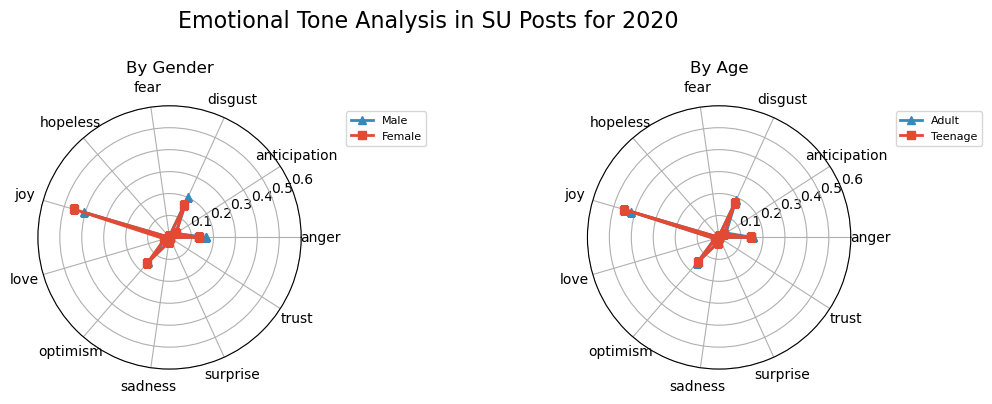

In [580]:
for i, y in enumerate([2020]):
    data = pd.concat(all_data[y], axis=1) 
    normalized_data = data.div(data.sum(axis=0), axis=1)
    # print(normalized_data)
    plot_all_trends(normalized_data, f'Emotional Tone Analysis in SU Posts for {y}',f'{y}')

## 2. For  all drug types

In [ ]:
def plot_radar(ax, values, color):
    feature = ['anger', 'anticipation', 'disgust', 'fear', 'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust']
    N= len(feature)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    ax.plot(angles + angles[:1], values + values[:1], color=color, marker= 'o', markersize=6)
    ax.fill(angles + angles[:1], values + values[:1], alpha=0.25, color=color)
    ax.set_ylim(0.0, 1.1)  
    
    ax.set_thetagrids(np.degrees(angles), feature)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    ax.grid(True)
    # ax.legend(loc='upper left', bbox_to_anchor=(1.15,1), ncol=1, frameon=True, fancybox=True, shadow=False, fontsize=8)
    # ax.legend(None)

## 2.1 Plot 3 charts for each drug in 2019, 2020, 2021

In [ ]:
def plot_by_drug_types(all_data, main_title, filename, drug_cols):
    fig, axs = plt.subplots(len(drug_cols), len(all_data), figsize=(10, 16), subplot_kw={'polar': True})
    red_rgb = '#E24A33'
    blue_rgb = '#348ABD'
    green_rgb = '#32CD32'
    colors =[blue_rgb, red_rgb, green_rgb]
    years = [2019, 2020, 2021]
    for j, year_data in enumerate(all_data):
        for i, d in enumerate(drug_cols):
            ax = axs[i, j]
            df = year_data[year_data['drug_type']==d][['anger', 'anticipation', 'disgust', 'fear', 'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust']].sum()
            numbers_array = np.array(df)
            normalized_numbers = (numbers_array - numbers_array.min()) / (numbers_array.max() - numbers_array.min())
            normalized_list = normalized_numbers.tolist()
            plot_radar(ax, normalized_list, colors[j])
            ax.set_title(f'{years[j]}', fontsize=12)
            # ax.text(0.1, 0.05, f'{drugs_map[d]}', fontsize=12, fontweight='bold')
    for i, d in enumerate(drug_cols):
        axs[i, 0].text(-0.2, 1.2, f'{drugs_map[d]}', fontsize=14, fontweight='bold', transform=axs[i, 0].transAxes)

    for j in range(len(drug_cols), len(axs)):
        fig.delaxes(axs[j])
    fig.suptitle(main_title, fontsize=16)
    plt.subplots_adjust(wspace = 0.3, hspace=0.2, top=0.95, bottom=0.05)  
    # plt.savefig(filename+'_00_radar_plots.png', bbox_inches='tight')
    plt.show()

In [ ]:
plot_by_drug_types([df_2019, df_2020, df_2021], f'Emotional Tone Analysis in SU Posts', 'I',  ['tobacco', 'alcohol'] )

In [ ]:
plot_by_drug_types([df_2019, df_2020, df_2021], f'Emotional Tone Analysis in SU Posts ','II', ['stimulants', 'club_drugs', ])

In [ ]:
plot_by_drug_types([df_2019, df_2020, df_2021], f'Emotional Tone Analysis in SU Posts ', 'III', [ 'dissociative_drugs', 'hallucinogens','other_compounds', 'prescription_medications'])

## 2.2 Plot a single chart for each drug


In [476]:
def plot_AA(all_data, main_title, filename, drug_cols):
    fig, axs = plt.subplots(5, 2, figsize=(10, 16), subplot_kw={'polar': True})
    axs = axs.flatten()
    colors =['#348ABD', '#E24A33', '#32CD32']
    years = [2019, 2020, 2021]
    for i, d in enumerate(drug_cols):
        if i >= len(axs):
            continue
        ax = axs[i]
        df = all_data[all_data['drug_type']==d][['anger', 'anticipation', 'disgust', 'fear', 'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust']].sum()
        numbers_array = np.array(df)
        normalized_numbers = (numbers_array - numbers_array.min()) / (numbers_array.max() - numbers_array.min())
        normalized_list = normalized_numbers.tolist()
        plot_radar(ax, normalized_list, colors[1])
        ax.text(0, 1.2, f'{drugs_map[d]}', fontsize=12, fontweight='bold',transform=ax.transAxes)

    for j in range(len(drug_cols), len(axs)):
        fig.delaxes(axs[j])
    # fig.suptitle(main_title, fontsize=16)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.6, top=0.93)  
    plt.savefig(f'{filename}_Radar_plot_for_all_drugs.png', bbox_inches='tight')
    plt.show()

In [466]:
data= pd.concat([df_2019, df_2020, df_2021], ignore_index=True)

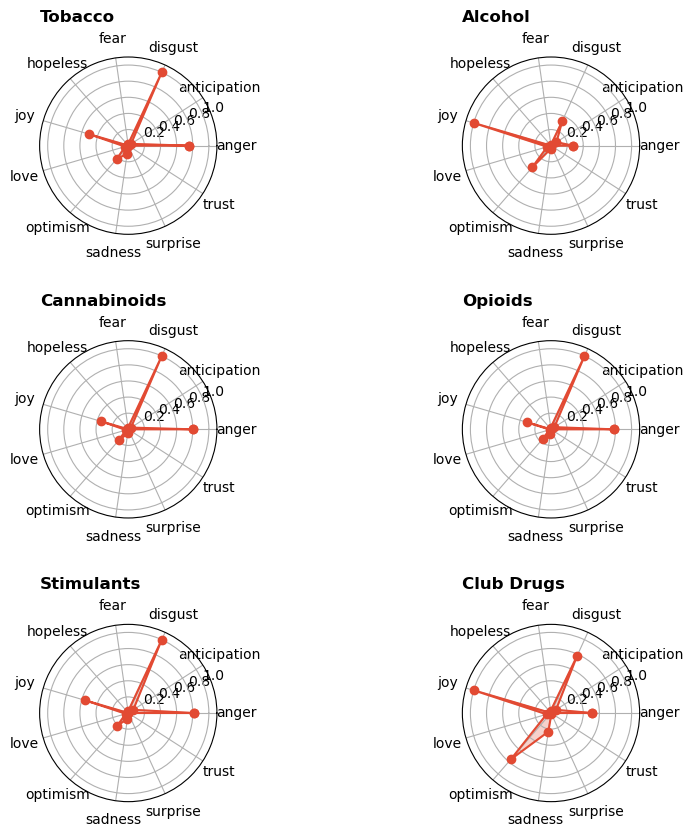

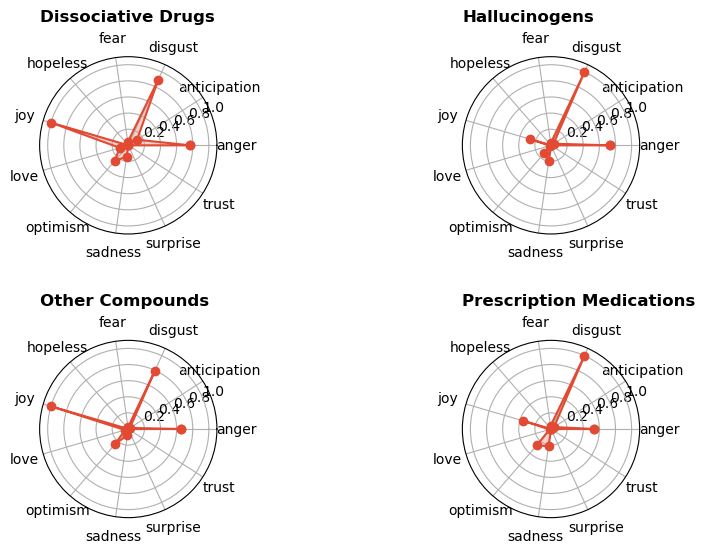

In [478]:
plot_AA(data, f'Emotional Tone in SU Posts', 'I', drug_cols[:6] )
plot_AA(data, f'Emotional Tone in SU Posts', 'II', drug_cols[6:] )

In [470]:
data['created_at'] = pd.to_datetime(data['created_at'], format='%a %b %d %H:%M:%S %z %Y')
pandemic_data = data[(data['created_at'] >= '2020-03-15') & (data['created_at'] <= '2020-06-15')]

In [471]:
pandemic_data

,id,created_at,text,user_id,name,screen_name,description,DrugAbuse,lang,gender,...,anticipation,disgust,fear,hopeless,joy,love,optimism,sadness,surprise,trust
